# Init

In [1]:
import os, sys
print( sys.version )
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO and WARNING messages are not printed
import glob
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt

gpus = tensorflow.config.experimental.list_physical_devices(device_type='GPU')
print( f"Found {len(gpus)} GPUs!" )
for i in range( len( gpus ) ):
    try:
        tensorflow.config.experimental.set_memory_growth(device=gpus[i], enable=True)
        tensorflow.config.experimental.VirtualDeviceConfiguration( memory_limit = 1024*3 )
        print( f"\t{tensorflow.config.experimental.get_device_details( device=gpus[i] )}" )
    except RuntimeError as e:
        print( '\n', e, '\n' )

devices = tensorflow.config.list_physical_devices()
print( "Tensorflow sees the following devices:" )
for dev in devices:
    print( f"\t{dev}" )

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Found 1 GPUs!
	{'compute_capability': (7, 5), 'device_name': 'GeForce RTX 2070'}
Tensorflow sees the following devices:
	PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
	PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
def graph_episode_output( res, ts_ms = 20 ):
    """ Graph the result of `simulate_episode_input` """
    N = res.shape[0]
    L = res.transpose()
    X = np.arange(0, N*ts_ms, ts_ms) 
    plt.figure()
    # print( X.shape, L.shape )
    plt.stackplot(X, *L, labels=("Pr(Pass)", "Pr(Fail)"), baseline='zero')
    plt.legend()
    plt.axis('tight')
    plt.show()
    
    
def scan_output_for_decision( output, trueLabel, threshold = 0.95 ):
    for i, row in enumerate( output ):
        if np.amax( row ) >= threshold:
            if np.dot( row, trueLabel ) >= threshold:
                ans = 'T'
            else:
                ans = 'F'
            if row[0] > row[1]:
                ans += 'P'
            else:
                ans += 'N'
            return ans, i
    return 'NC', output.shape[0]

# Load Data

In [3]:
from random import shuffle

# _DATADIR  = os.path.expanduser("/home/james/Efficiency_from_Failure_Classification/RAL2022/data/2022-08-16_Twist/TWST_NRM/")
_DATADIR  = os.path.join(os.path.abspath("./"), "comp_data/")
_SHUFFLE  = 1

ext      = "*.npy"
npyFiles = glob.glob( _DATADIR + ext )
print( f"Found {len(npyFiles)} {ext} files!" )

if _SHUFFLE:
    shuffle( npyFiles )
    print( "Shuffled files!" )

epData = []
N_s    = 0
N_f    = 0
for file in npyFiles:
    epMatx = np.array( np.load( file ) ).astype( dtype = float )
    # print( epMatx[0,7] )
    if epMatx[0,7] == 1.0:
        N_s += 1
    elif epMatx[0,7] == 0.0:
        N_f += 1
    epData.append( epMatx )
    print( '>', end=' ' )
    
print( f"\nCreated {len(epData)} episode matrices!" )
print( f"{N_s} successes, {N_f} failures, Success Rate: {N_s/(N_s+N_f)}, Failure Rate: {N_f/(N_s+N_f)}" )

# print( epData[100][100,:] )

Found 90 *.npy files!
Shuffled files!
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
Created 90 episode matrices!
48 successes, 42 failures, Success Rate: 0.5333333333333333, Failure Rate: 0.4666666666666667


# Data Preprocessing

In [4]:
import matplotlib.pyplot as plt

def plot_FT( data_np, figsize=(18, 14), dpi=80, suppressT = 0 ):
    """ Interpret `data_np` as force-torque """
    x  = data_np[:,0]
    fx = data_np[:,1]
    fy = data_np[:,2]
    fz = data_np[:,3]
    tx = data_np[:,4]
    ty = data_np[:,5]
    tz = data_np[:,6]
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot( x , fx , label='Fx' )
    plt.plot( x , fy , label='Fy' )
    plt.plot( x , fz , label='Fz' )
    plt.xlabel( 'Time in millisecs' )
    plt.ylabel( 'Forces' )
    plt.title( 'Forces vs time ' )
    plt.legend()
    plt.show()

    if not suppressT:
        plt.figure(figsize=figsize, dpi=dpi)
        plt.plot( x , tx , label='Tx' )
        plt.plot( x , ty , label='Ty' )
        plt.plot( x , tz , label='Tz' )
        plt.xlabel( 'Time in millisecs' )
        plt.ylabel( 'Torques' )
        plt.title( 'Torques vs time ' )
        plt.legend()
        plt.show()

## Begin each ep at 1st impact

In [5]:
truncData   = []
winWidth    = 10
FzCol       =  3
spikeThresh = 0.05
vb          = 0

# For every episode
for j, epMatx in enumerate( epData ):
    # Look for the first spike in F_z
    N          = epMatx.shape[0]
    if vb:
        print( f"{j}\n{epMatx.shape} input data shape" )
    chopDex    = 0
    for bgn in range( int(1.5*50), N-winWidth+1 ):
        end     = bgn+winWidth
        FzSlice = epMatx[ bgn:end, FzCol ].flatten()
        # print( FzSlice.shape )
        # print( np.amax( FzSlice ), np.amin( FzSlice ), type( np.amax( FzSlice ) - np.amin( FzSlice ) ) )
        if np.abs( np.amax( FzSlice ) - np.amin( FzSlice ) ) >= spikeThresh:
            # print( np.amax( FzSlice ), np.amin( FzSlice ) )
            # print( FzSlice )
            chopDex = bgn
            if vb:
                print( f"Relevant data at {chopDex*20/1000.0} seconds!" )
            break
    if (chopDex*20/1000) < 15.0:
        truncData.append( epMatx[ chopDex:,: ] )
    # else dump an episode that does not fit criteria, 2022-08-31: Dumped 5 episodes
    if vb:
        print( f"{ truncData[-1].shape } output data shape" )
        print()
    else:
        print( '>', end=' ' )
    
print( f"\nTruncated {len(truncData)} episodes!" )
            
# plot_FT( truncData[1][:,0:7], suppressT = 1 )

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
Truncated 90 episodes!


## Get windows of at least 1 complete twist (7s?)

In [6]:
rollWinWidth = int(7.0 * 50) #int(8.5 * 50)
windowData   = []
for j, epMatx in enumerate( truncData ):
    R = epMatx.shape[0]
    # C = epMatx.shape[1]
    L = R - rollWinWidth + 1
    epWindows = np.zeros( (L,rollWinWidth,7,) )
    for i in range(L):
        end = i+rollWinWidth
        epWindows[i,:,:] = epMatx[ i:end, 1:8 ]
    windowData.append( epWindows )
    print( f'{epWindows.shape}', end=' ' )
print( "\nDONE!" )

(496, 350, 7) (496, 350, 7) (495, 350, 7) (495, 350, 7) (3025, 350, 7) (495, 350, 7) (495, 350, 7) (3090, 350, 7) (495, 350, 7) (2050, 350, 7) (1020, 350, 7) (495, 350, 7) (499, 350, 7) (3007, 350, 7) (1534, 350, 7) (3077, 350, 7) (1017, 350, 7) (2982, 350, 7) (2971, 350, 7) (419, 350, 7) (1019, 350, 7) (3004, 350, 7) (3009, 350, 7) (494, 350, 7) (500, 350, 7) (3001, 350, 7) (2563, 350, 7) (3017, 350, 7) (3012, 350, 7) (2988, 350, 7) (2996, 350, 7) (2999, 350, 7) (496, 350, 7) (492, 350, 7) (3001, 350, 7) (2985, 350, 7) (3024, 350, 7) (500, 350, 7) (496, 350, 7) (2981, 350, 7) (494, 350, 7) (2980, 350, 7) (2986, 350, 7) (3000, 350, 7) (3014, 350, 7) (2997, 350, 7) (2982, 350, 7) (495, 350, 7) (2985, 350, 7) (469, 350, 7) (2978, 350, 7) (2989, 350, 7) (2983, 350, 7) (415, 350, 7) (2570, 350, 7) (2999, 350, 7) (504, 350, 7) (2993, 350, 7) (3087, 350, 7) (1024, 350, 7) (2983, 350, 7) (3015, 350, 7) (502, 350, 7) (3012, 350, 7) (496, 350, 7) (1013, 350, 7) (2971, 350, 7) (491, 350, 7) (495

## Stack all windows into a massive dataset

Separate Train/Test by EPISODE

In [7]:
from tensorflow.keras.utils import to_categorical

testFrac     = 0.20
N_ep         = len( windowData )
N_test       = int(N_ep * testFrac)
N_train      = N_ep - N_test
trainWindows = 0
testWindows  = 0

print( f"{N_train} episodes for Training and {N_test} epsiodes for Testing" )

72 episodes for Training and 18 epsiodes for Testing


In [8]:
i = 0

for j in range( N_train ):
    ep = windowData[i]
    trainWindows += ep.shape[0]
    i += 1
    
for j in range( N_test ):
    ep = windowData[i]
    testWindows += ep.shape[0]
    i += 1

print( f"{trainWindows} windows to Train and {testWindows} to Test" )
print( f"All episodes accounted for?: {i == N_ep}, {i}, {N_ep}" )

datasetTrain = np.zeros( (trainWindows, windowData[0].shape[1], windowData[0].shape[2],) )
datasetTest  = np.zeros( (testWindows , windowData[0].shape[1], windowData[0].shape[2],) )

i = 0
j = 0
for _ in range( N_train ):
    ep = windowData[i]
    for window in ep:
        datasetTrain[j,:,:] = window
        j += 1
    i += 1
    print( "T", end = " " )
    
j = 0
    
for _ in range( N_test ):
    ep = windowData[i]
    for window in ep:
        datasetTest[j,:,:] = window
        j += 1
    i += 1
    print( "V", end = " " )
        
        
X_train = datasetTrain[ :, :, 0:6 ]
Y_train = np.zeros( (trainWindows, 1) )
print( f"\nTrain X shape: {X_train.shape}" )
print( f"\nTrain Y shape: {Y_train.shape}" )

X_test = datasetTest[ :, :, 0:6 ]
Y_test = np.zeros( (testWindows, 1) )
print( f"\nTest X shape: {X_test.shape}" )
print( f"\nTest Y shape: {Y_test.shape}" )

134135 windows to Train and 41785 to Test
All episodes accounted for?: True, 90, 90
T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T T V V V V V V V V V V V V V V V V V V 
Train X shape: (134135, 350, 6)

Train Y shape: (134135, 1)

Test X shape: (41785, 350, 6)

Test Y shape: (41785, 1)


In [9]:
i   = 0 
k   = 0
pos = 0
neg = 0

for j in range( N_train ):
    ep = windowData[i]
    for window in ep:
        if datasetTrain[k,0,6] == 1.0:
            Y_train[k,0] = 0
            pos += 1
        elif datasetTrain[k,0,6] == 0.0:
            Y_train[k,0] = 1
            neg += 1
        else:
            raise ValueError( "BAD LABEL" )
        k += 1
    i += 1
    print( i, end = " " )
    
k = 0

for j in range( N_test ):
    ep = windowData[i]
    # print()
    for window in ep:
        # print(datasetTest[k,0,6], end=' ')
        # print( datasetTest[k,-1,:] )
        if datasetTest[k,0,6] == 1.0:
            Y_test[k,0] = 0
            pos += 1
        elif datasetTest[k,0,6] == 0.0:
            Y_test[k,0] = 1
            neg += 1
        else:
            raise ValueError( "BAD LABEL" )
        k += 1
    i += 1
    print( i, end = " " )
    
print( '\n' )
print( Y_train.shape, Y_test.shape )
Y_train = to_categorical( Y_train )
Y_test  = to_categorical( Y_test  )
print( Y_train.shape, Y_test.shape )
    
print( f"\nThere are {pos} passing windows and {neg} failing windows!, Total: {pos+neg}" )

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 

(134135, 1) (41785, 1)
(134135, 2) (41785, 2)

There are 50007 passing windows and 125913 failing windows!, Total: 175920


In [10]:
X_winTest = []
Y_winTest = []

for i in range( N_train, N_ep ):
    ep = windowData[i]
    X_winTest.append( ep[ :, :, 0:6 ] )
    y_i = np.zeros( (ep.shape[0], 2) )
    if ep[ 0, 0, 6 ] == 1.0:
        y_i[:,:] = [1.0, 0.0]
        Y_winTest.append( y_i ) 
    elif ep[ 0, 0, 6 ] == 0.0:
        y_i[:,:] = [0.0, 1.0]
        Y_winTest.append( y_i )
    print( '>', end=' ' )
    
print( f"\nDONE! Captured {len(X_winTest)}/{len(Y_winTest)} TEST episodes." )


> > > > > > > > > > > > > > > > > > 
DONE! Captured 18/18 TEST episodes.


## Build FCN

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, SimpleRNN, LSTM, GRU, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers



model = Sequential()

# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
model.add(Conv1D( # "Dilated Convolution Layer 1 (No. of filters = 8, Filter Size = 2, Dilation Rate = 2)"
    filters       = 16, #32 #16 #8, 
    kernel_size   =  4, #2, 
    dilation_rate =  4, #2,
    activation  = 'relu', # -------- "a sequence of layers of dilated convolutional layers with ReLU"
    input_shape = (rollWinWidth, 6,) #(n_steps, n_features)
))

model.add(Conv1D( # "Dilated Convolution Layer 2 (No. of filters = 8, Filter Size = 2, Dilation Rate = 4)"
    filters       = 16, #32 #16 # 8, 
    kernel_size   =  4, #2, 
    dilation_rate =  8, #4,
    activation  = 'relu', # -------- "a sequence of layers of dilated convolutional layers with ReLU"
    input_shape = (rollWinWidth, 6,) #(n_steps, n_features)
))

# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
model.add( MaxPooling1D( pool_size = 4 ) ) #"Max Pooling Layer"

model.add( Flatten() )

model.add( Dense(50) ) # 50 # 200 #100 # fully connected layer
model.add( Activation('relu') )

model.add( Dropout( rate = 0.5 ) ) # "We used drop out at a rate of 0.5"

model.add( Dense( 2 ) ) # "The softmax layer computes the probability values for the predicted class."
model.add( Activation( "softmax" ) )
model.summary()

model.compile(
    # optimizer=Adam(
    #     beta_1 = 0.9, #0.7,#0.8, #0.9, # - "β1 = 0.9"
    #     beta_2 = 0.999, #0.799,#0.85, #0.999, # "β2 = 0.999"
    # ),
    optimizer = SGD( 
        learning_rate = 0.0010, # 0.0015 #0.002 # 0.004
        momentum      = 0.125 #0.25 # 0.50 # 0.75
    ),
    loss      = 'categorical_crossentropy', #'MSE' 
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 338, 16)           400       
                                                                 
 conv1d_1 (Conv1D)           (None, 314, 16)           1040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 78, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1248)              0         
                                                                 
 dense (Dense)               (None, 50)                62450     
                                                                 
 activation (Activation)     (None, 50)                0         
                                                        

In [12]:
print( X_train.shape )
print( Y_train.shape )
print( X_test.shape )
print( Y_test.shape )

(134135, 350, 6)
(134135, 2)
(41785, 350, 6)
(41785, 2)


In [13]:
batchSize = 256 #128 #256 #512 (out of mem) #256 #128

with tensorflow.device('/GPU:0'):
    history = model.fit( 
        # X_train, Y_train.reshape((-1,2)), 
        X_train, Y_train, 
        # validation_data  = (X_test, Y_test.reshape((-1,2)) ),
        validation_data  = (X_test, Y_test),
        batch_size       = batchSize, 
        epochs           = 200, #250, #50, #250, # 2022-09-12: Trained for 250 total
        verbose          = True, 
        # validation_split =   0.2,
        steps_per_epoch  = int(trainWindows/batchSize), # https://stackoverflow.com/a/49924566
    )

Epoch 1/200
523/523 [==============================] - 10s 7ms/step - loss: 0.5828 - accuracy: 0.6996 - val_loss: 0.6158 - val_accuracy: 0.7189
Epoch 2/200
523/523 [==============================] - 3s 5ms/step - loss: 0.5259 - accuracy: 0.7350 - val_loss: 0.6218 - val_accuracy: 0.7330
Epoch 3/200
523/523 [==============================] - 3s 5ms/step - loss: 0.5069 - accuracy: 0.7466 - val_loss: 0.6330 - val_accuracy: 0.7366
Epoch 4/200
523/523 [==============================] - 3s 5ms/step - loss: 0.4941 - accuracy: 0.7544 - val_loss: 0.6360 - val_accuracy: 0.7426
Epoch 5/200
523/523 [==============================] - 3s 5ms/step - loss: 0.4838 - accuracy: 0.7611 - val_loss: 0.6512 - val_accuracy: 0.7436
Epoch 6/200
523/523 [==============================] - 3s 5ms/step - loss: 0.4739 - accuracy: 0.7686 - val_loss: 0.6573 - val_accuracy: 0.7371
Epoch 7/200
523/523 [==============================] - 3s 6ms/step - loss: 0.4646 - accuracy: 0.7745 - val_loss: 0.6585 - val_accuracy: 0.738

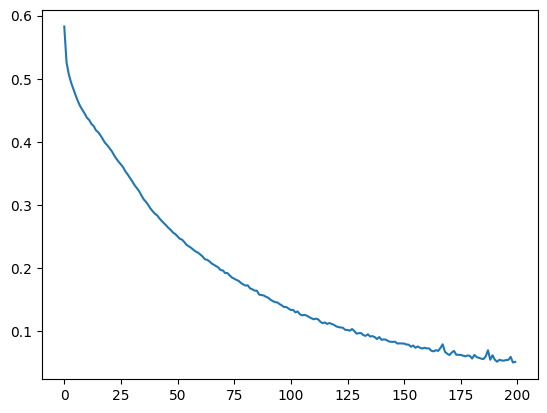

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

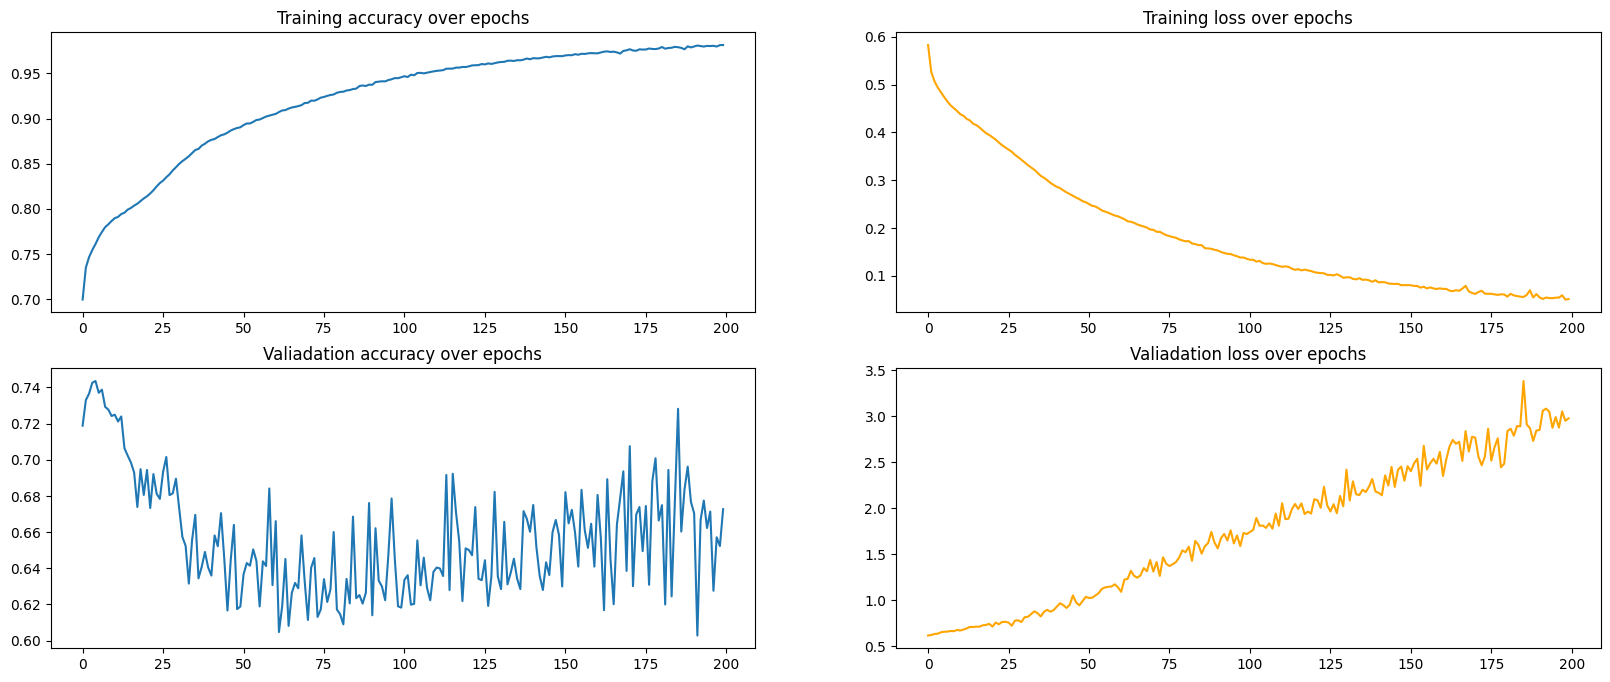

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes[0, 0].plot(accuracy, label='Training accuracy')
axes[0, 0].title.set_text('Training accuracy over epochs')
axes[0, 1].plot(np.array(loss), label='Training loss', color='orange')
axes[0, 1].title.set_text('Training loss over epochs')



axes[1, 0].plot(val_accuracy, label='Validation accuracy')
axes[1, 0].title.set_text('Valiadation accuracy over epochs')
axes[1, 1].plot(np.array(val_loss), label='Validation loss', color='orange')
axes[1, 1].title.set_text('Valiadation loss over epochs')


plt.show()

In [18]:
print( X_test.shape )
print( Y_test.shape )



with tensorflow.device('/GPU:0'):
    predictions = np.round(model.predict(X_test[0:3,:,:]))
    print( predictions )
    print( Y_test[0:3,:] )
    errors      = abs(predictions-Y_test[0:3,:])
    print('Error: ',sum(errors)/len(Y_test)*100,'%')

(41785, 350, 6)
(41785, 2)
1/1 [==============================] - 0s 106ms/step
[[1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]]
Error:  [0.00717961 0.00717961] %


In [19]:
from utils import CounterDict

fName = "FCN-5.keras"

model.save( fName )

perf = CounterDict()

for epNo in range( len( X_winTest ) ):    
    print( '>', end=' ' )
    with tensorflow.device('/GPU:0'):
        res = model.predict( X_winTest[epNo] )
        ans, aDx = scan_output_for_decision( res, Y_winTest[epNo][0], threshold = 0.90 )
        perf.count( ans )
        
print( '\n', fName, '\n', perf )

confMatx = {
    # Actual Positives
    'TP' : (perf['TP'] if ('TP' in perf) else 0) / ((perf['TP'] if ('TP' in perf) else 0) + (perf['FN'] if ('FN' in perf) else 0)),
    'FN' : (perf['FN'] if ('FN' in perf) else 0) / ((perf['TP'] if ('TP' in perf) else 0) + (perf['FN'] if ('FN' in perf) else 0)),
    # Actual Negatives
    'TN' : (perf['TN'] if ('TN' in perf) else 0) / ((perf['TN'] if ('TN' in perf) else 0) + (perf['FP'] if ('FP' in perf) else 0)),
    'FP' : (perf['FP'] if ('FP' in perf) else 0) / ((perf['TN'] if ('TN' in perf) else 0) + (perf['FP'] if ('FP' in perf) else 0)),
    'NC' : (perf['NC'] if ('NC' in perf) else 0) / len( X_winTest ),
}

print( confMatx )

ModuleNotFoundError: No module named 'utils'

94/94 [==============================] - 0s 2ms/step
[0. 1.] 

('FP', 0)


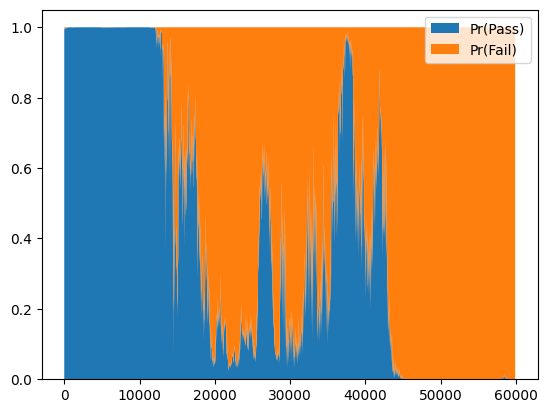


94/94 [==============================] - 0s 1ms/step
[0. 1.] 

('TN', 0)


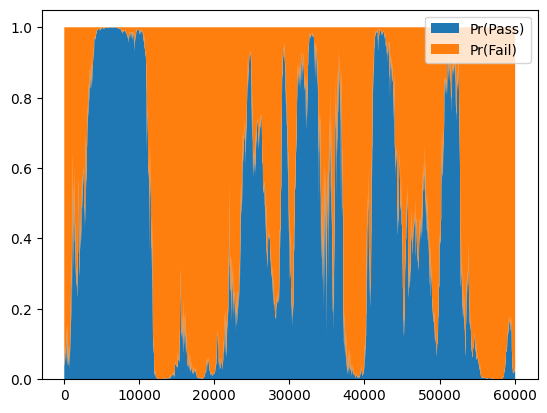


80/80 [==============================] - 0s 1ms/step
[1. 0.] 

('FN', 0)


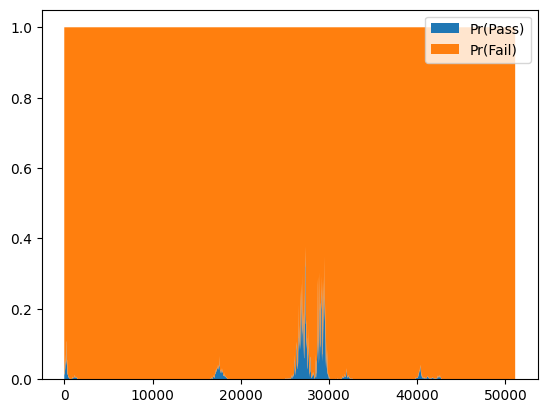


93/93 [==============================] - 0s 1ms/step
[0. 1.] 

('FP', 7)


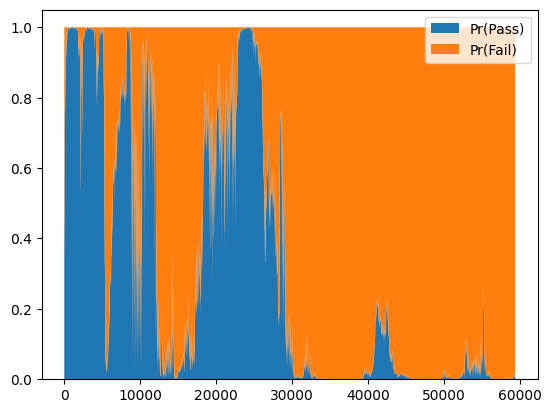


95/95 [==============================] - 0s 1ms/step
[0. 1.] 

('FP', 0)


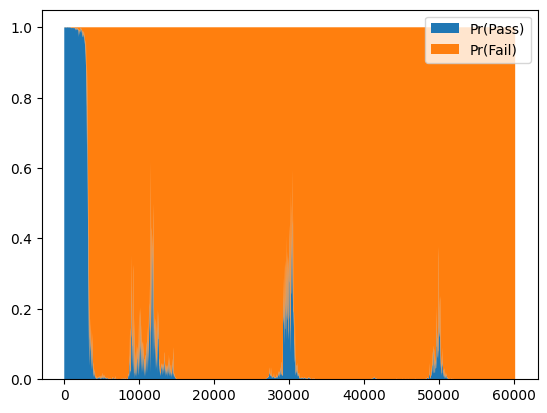


16/16 [==============================] - 0s 1ms/step
[1. 0.] 

('TP', 0)


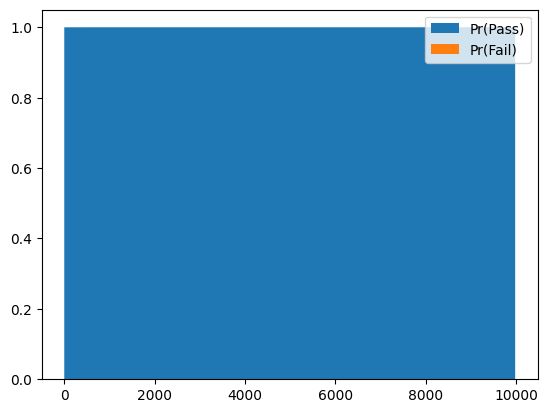


48/48 [==============================] - 0s 1ms/step
[1. 0.] 

('FN', 0)


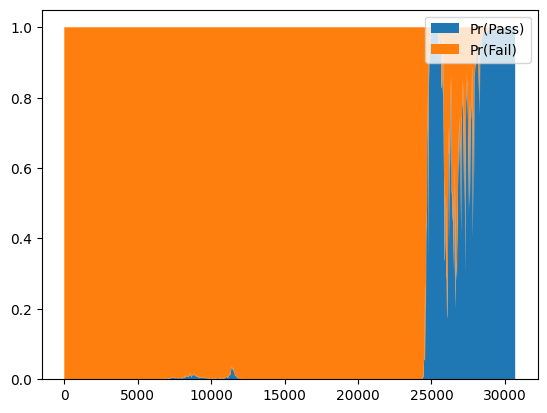


95/95 [==============================] - 0s 1ms/step
[0. 1.] 

('TN', 94)


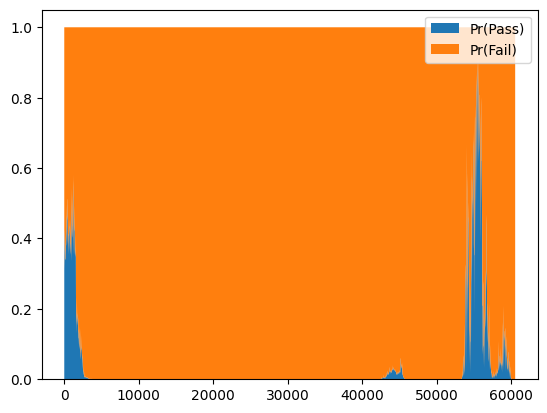


33/33 [==============================] - 0s 2ms/step
[1. 0.] 

('TP', 0)


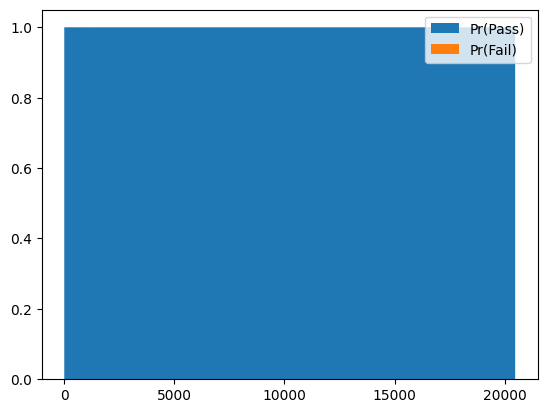


95/95 [==============================] - 0s 1ms/step
[0. 1.] 

('TN', 0)


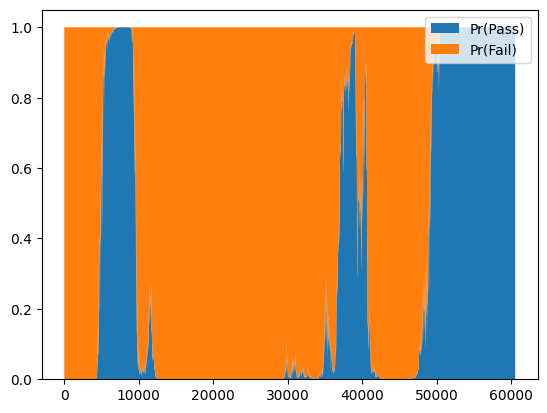


16/16 [==============================] - 0s 3ms/step
[1. 0.] 

('TP', 73)


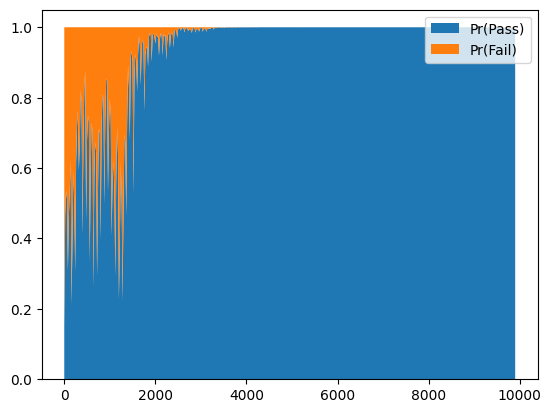


93/93 [==============================] - 0s 1ms/step
[0. 1.] 

('TN', 0)


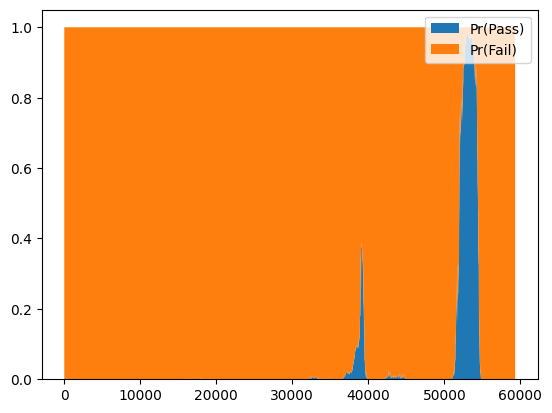


16/16 [==============================] - 0s 3ms/step
[1. 0.] 

('TP', 0)


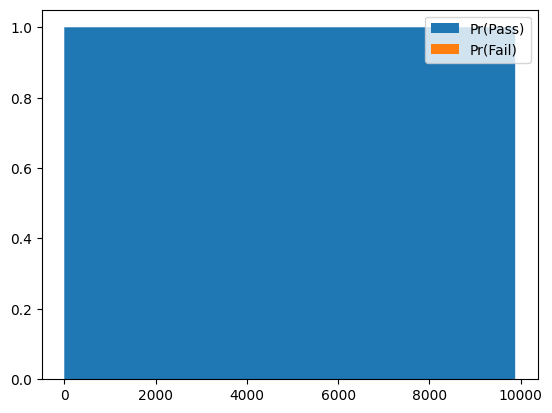


97/97 [==============================] - 0s 1ms/step
[1. 0.] 

('FN', 0)


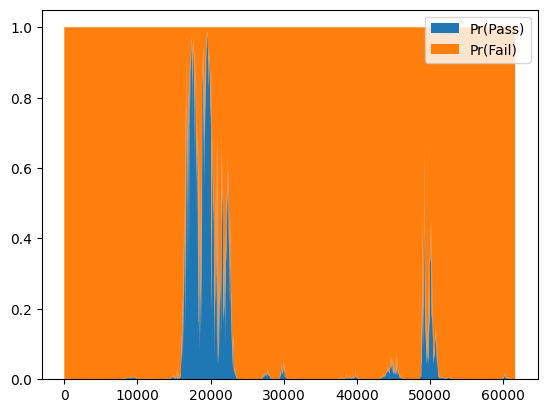


95/95 [==============================] - 0s 1ms/step
[0. 1.] 

('FP', 0)


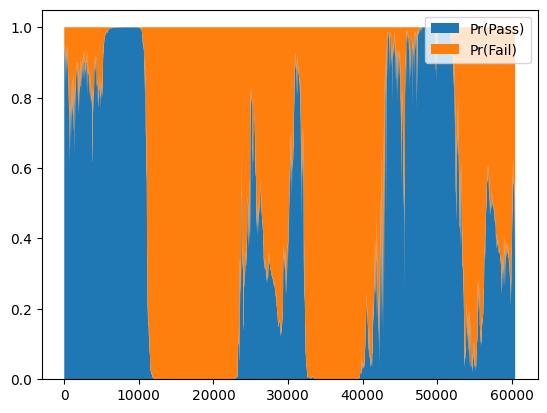


65/65 [==============================] - 0s 1ms/step
[1. 0.] 

('TP', 0)


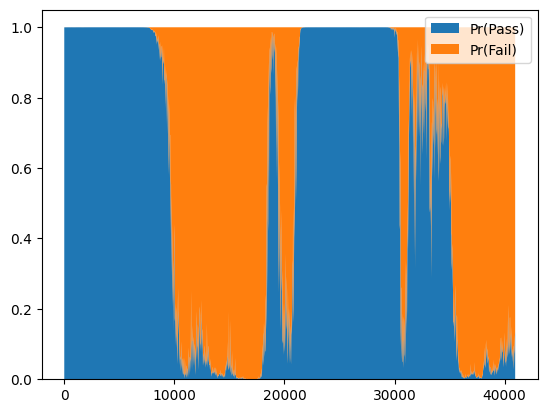


95/95 [==============================] - 0s 1ms/step
[0. 1.] 

('FP', 70)


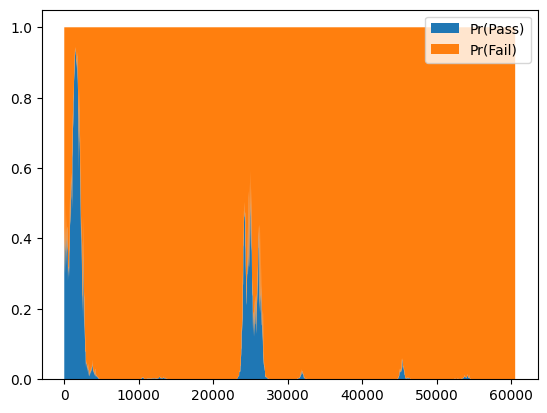


94/94 [==============================] - 0s 1ms/step
[0. 1.] 

('TN', 0)


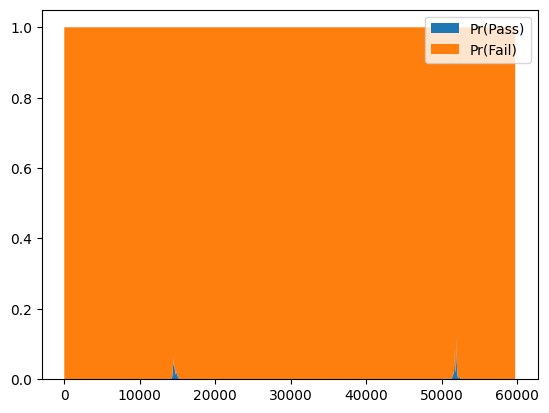

: 

In [20]:
for epNo in range( len( X_winTest ) ):    
    with tensorflow.device('/GPU:0'):
        res = model.predict( X_winTest[epNo] )
        print( Y_winTest[epNo][0], '\n' )
        print( scan_output_for_decision( res, Y_winTest[epNo][0], threshold = 0.90 ) )
        graph_episode_output( res, ts_ms = 20 )
        print()
    # print( res )

In [24]:
tensorflow.keras.utils.plot_model(
    model, to_file=fName+'.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Build Transformer

In [25]:
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [27]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=2
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)
model.summary()

checkpoint_filepath = './models/tmp/checkpoints/'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True
    )
]

history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

evaluation = model.evaluate(X_test, Y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 350, 6)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 350, 6)      12          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 350, 6)      27654       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

In [ ]:
loss = history.history['loss']
acc = history.history['categorical_accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_categorical_accuracy']

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes[0, 0].plot(acc, label='Training accuracy')
axes[0, 0].title.set_text('Training accuracy over epochs')
axes[0, 1].plot(np.array(loss), label='Training loss', color='orange')
axes[0, 1].title.set_text('Training loss over epochs')



axes[1, 0].plot(val_acc, label='Validation accuracy')
axes[1, 0].title.set_text('Valiadation accuracy over epochs')
axes[1, 1].plot(np.array(val_loss), label='Validation loss', color='orange')
axes[1, 1].title.set_text('Valiadation loss over epochs')


plt.show()

In [ ]:
print( X_test.shape )
print( Y_test.shape )



with tensorflow.device('/GPU:0'):
    predictions = np.round(model.predict(X_test[0:3,:,:]))
    print( predictions )
    print( Y_test[0:3,:] )
    errors      = abs(predictions-Y_test[0:3,:])
    print('Error: ',sum(errors)/len(Y_test)*100,'%')

In [ ]:
from utils import CounterDict

fName = "FCN-5.keras"

model.save( fName )

perf = CounterDict()

for epNo in range( len( X_winTest ) ):    
    print( '>', end=' ' )
    with tensorflow.device('/GPU:0'):
        res = model.predict( X_winTest[epNo] )
        ans, aDx = scan_output_for_decision( res, Y_winTest[epNo][0], threshold = 0.90 )
        perf.count( ans )
        
print( '\n', fName, '\n', perf )

confMatx = {
    # Actual Positives
    'TP' : (perf['TP'] if ('TP' in perf) else 0) / ((perf['TP'] if ('TP' in perf) else 0) + (perf['FN'] if ('FN' in perf) else 0)),
    'FN' : (perf['FN'] if ('FN' in perf) else 0) / ((perf['TP'] if ('TP' in perf) else 0) + (perf['FN'] if ('FN' in perf) else 0)),
    # Actual Negatives
    'TN' : (perf['TN'] if ('TN' in perf) else 0) / ((perf['TN'] if ('TN' in perf) else 0) + (perf['FP'] if ('FP' in perf) else 0)),
    'FP' : (perf['FP'] if ('FP' in perf) else 0) / ((perf['TN'] if ('TN' in perf) else 0) + (perf['FP'] if ('FP' in perf) else 0)),
    'NC' : (perf['NC'] if ('NC' in perf) else 0) / len( X_winTest ),
}

print( confMatx )

In [ ]:
for epNo in range( len( X_winTest ) ):    
    with tensorflow.device('/GPU:0'):
        res = model.predict( X_winTest[epNo] )
        print( Y_winTest[epNo][0], '\n' )
        print( scan_output_for_decision( res, Y_winTest[epNo][0], threshold = 0.90 ) )
        graph_episode_output( res, ts_ms = 20 )
        print()
    # print( res )

In [ ]:
model.save('models/transformer')

# Load previously trained models

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = tensorflow.keras.models.load_model( "models/FCN-5.keras" )